# Sentiment Analysis 

<b>Please note that the values can be slightly different from the ones in the report due to running the machine learning algorithm at different times</b>

The values in the report are final.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import shap
import random
import warnings
warnings.filterwarnings('ignore')

/Users/weixin/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/Users/weixin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidanc

### Loading the dataset

In [2]:
testdf = pd.read_csv("data/twitter_test.csv")
traindf = pd.read_csv("data/twitter_train.csv")
traindf.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
print(traindf.sentiment.value_counts())

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64


In [4]:
# check if there are any NaN values for training data
traindf[traindf.isna().any(axis=1)]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [5]:
# check if there are any NaN values for test data
testdf[testdf.isna().any(axis=1)]

,textID,text,sentiment


In [6]:
traindf = traindf.dropna()
# check again if there are any NaN values
traindf[traindf.isna().any(axis=1)]

,textID,text,selected_text,sentiment


In [7]:
import re
# Remove mentions in tweets
def clean_text(row, options):

    if options['remove_url']:
        row = re.sub("http\S+|www.\S+","", row)

    if options['remove_mentions']:
        row = re.sub("@[A-Za-z0-9]+","", row)
        
    if options['remove_hashtags']:
        row = re.sub("#","", row)

    return row

clean_config = {
    'remove_url': True,
    'remove_mentions': True,
    'remove_hashtags': True,
    }

def encode_sentiment(x):
    if x == 'positive':
        return 1.0
    elif x == 'negative':
        return -1.0
    else:
        return 0.0


In [8]:
# clean text
traindf['text'] = traindf['text'].apply(clean_text, args=(clean_config,))
testdf['text'] = testdf['text'].apply(clean_text, args=(clean_config,))
traindf['sentiment'] = traindf['sentiment'].apply(encode_sentiment)
testdf['sentiment'] = testdf['sentiment'].apply(encode_sentiment)

In [9]:
obs_num = min(traindf['sentiment'].value_counts())

df_class_positive = traindf[traindf['sentiment'] == 1]
df_class_neutral = traindf[traindf['sentiment'] == 0]
df_class_negative = traindf[traindf['sentiment'] == -1]

sample_positive = df_class_positive.sample(obs_num)
sample_neutral = df_class_neutral.sample(obs_num)
sample_negative = df_class_negative.sample(obs_num)

#Concat and shuffle
traindf = pd.concat([sample_positive, sample_neutral, sample_negative], axis=0).sample(frac=1)

In [10]:
X = traindf["text"]
y = traindf["sentiment"]
X_train = X
X_test = testdf["text"]
y_train = y
y_test = testdf["sentiment"]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23343,)
(3534,)
(23343,)
(3534,)


### Comparing results using different approaches and methods

In [11]:
def tokenize_NB(X_train, y_train, X_test, y_test, vect):
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Naive Bayes')
    print('Features: ', X_train_dtm.shape[1])
    
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    
    # Get the training accuracy
    print('Training Accuracy: ', metrics.accuracy_score(y_train, nb.predict(X_train_dtm)))
    # print the accuracy of its predictions
    print('Test Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))
    print('F1 Score: ', metrics.f1_score(y_test, y_pred_class, average="weighted"))
    
def tokenize_Logistic(X_train, y_train, X_test, y_test, vect):
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('\nLogistic Regression')
    print('Features: ', X_train_dtm.shape[1])
    
    lr = LogisticRegression(max_iter=500)
    lr.fit(X_train_dtm, y_train)
    y_pred_class = lr.predict(X_test_dtm)
    
    # Get the training accuracy
    print('Training Accuracy: ', metrics.accuracy_score(y_train, lr.predict(X_train_dtm)))
    # print the accuracy of its predictions
    print('Test Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))
    print('F1 Score: ', metrics.f1_score(y_test, y_pred_class, average="weighted"))
    
def tokenize_features(X_train, y_train, X_test, y_test, vect):
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    
    arr = []
    arr.append(metrics.accuracy_score(y_train, nb.predict(X_train_dtm)))
    # print the accuracy of its predictions
    arr.append(metrics.accuracy_score(y_test, y_pred_class))
    return arr

def tokenize_features_lr(X_train, y_train, X_test, y_test, vect):
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)

    lr = LogisticRegression(max_iter=500)
    lr.fit(X_train_dtm, y_train)
    y_pred_class = lr.predict(X_test_dtm)
    
    arr = []
    arr.append(metrics.accuracy_score(y_train, lr.predict(X_train_dtm)))
    # print the accuracy of its predictions
    arr.append(metrics.accuracy_score(y_test, y_pred_class))
    return arr

In [12]:
# Gridsearch for Naive Bayes with Countvectorizer (take 133 min to run)
# p = Pipeline([
#     ('vect', CountVectorizer(lowercase=False)),
#     ('clf', MultinomialNB())])

# maxf = [None] + list(range(2000,12000,2000))

# params = [{'vect__max_features':maxf,
#            'vect__stop_words':["english", None],
#            'vect__min_df':list(range(1,10)),
#            'vect__max_df':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#            'vect__ngram_range':[(1,1), (1,2), (1,3), (1,4), (1,5)]}]
# g = GridSearchCV(p, param_grid=params,scoring="accuracy",verbose=10)
# g.fit(X_train, y_train)
# g.best_estimator_

In [13]:
# Gridsearch for Logistic Regression with Countvectorizer (take 454 min to run)
# plr = Pipeline([
#     ('vect', CountVectorizer(lowercase=False)),
#     ('clf', LogisticRegression())])

# maxf = [None] + list(range(2000,12000,2000))

# params = [{'vect__max_features':maxf,
#            'vect__stop_words':["english", None],
#            'vect__min_df':list(range(1,10)),
#            'vect__max_df':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#            'vect__ngram_range':[(1,1), (1,2), (1,3), (1,4), (1,5)]}]
# glr = GridSearchCV(plr, param_grid=params,scoring="accuracy",verbose=10)
# glr.fit(X_train, y_train)
# glr.best_estimator_

In [14]:
#Gridsearch for Naive Bayes with Tfidfvectorizer (takes about 304 min to run)
# p = Pipeline([
#     ('vect', TfidfVectorizer(lowercase=False)),
#     ('clf', MultinomialNB())])

# maxf = [None] + list(range(2000,12000,2000))

# params = [{'vect__max_features':maxf,
#            'vect__stop_words':["english", None],
#            'vect__min_df':list(range(1,10)),
#            'vect__max_df':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#            'vect__ngram_range':[(1,1), (1,2), (1,3), (1,4), (1,5)]}]
# g2 = GridSearchCV(p, param_grid=params,scoring="accuracy",verbose=10)
# g2.fit(X_train, y_train)
# g2.best_estimator_

In [15]:
#Gridsearch for Naive Bayes with Tfidfvectorizer (takes about 317 min to run)
# p = Pipeline([
#     ('vect', TfidfVectorizer(lowercase=False)),
#     ('clf', LogisticRegression())])

# maxf = [None] + list(range(2000,12000,2000))

# params = [{'vect__max_features':maxf,
#            'vect__stop_words':["english", None],
#            'vect__min_df':list(range(1,10)),
#            'vect__max_df':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#            'vect__ngram_range':[(1,1), (1,2), (1,3), (1,4), (1,5)]}]
# glr2 = GridSearchCV(p, param_grid=params,scoring="accuracy",verbose=10)
# glr2.fit(X_train, y_train)
# glr2.best_estimator_

In [16]:
random.seed(4222)
vect = CountVectorizer(lowercase=False, max_features=None, min_df= 6, max_df= 0.1 )
# NB
tokenize_NB(X_train, y_train, X_test, y_test, vect)

vect = CountVectorizer(lowercase=False, max_features=None, max_df= 0.1, min_df= 1, stop_words="english", ngram_range=(1,2))
# Logistic
tokenize_Logistic(X_train, y_train, X_test, y_test, vect)

Naive Bayes
Features:  3753
Training Accuracy:  0.7311827956989247
Test Accuracy:  0.629881154499151
F1 Score:  0.627569543130583

Logistic Regression
Features:  144317
Training Accuracy:  0.9838067086492739
Test Accuracy:  0.6847764572722128
F1 Score:  0.6857136704945003


In [17]:
vect = TfidfVectorizer(lowercase=False, max_df=0.1, max_features=None, min_df=1, ngram_range=(1, 5),stop_words="english")

# NB
tokenize_NB(X_train, y_train, X_test, y_test, vect)

vect = TfidfVectorizer(lowercase=False, max_df=0.1, max_features=10000)
# Logistic
tokenize_Logistic(X_train, y_train, X_test, y_test, vect)

Naive Bayes
Features:  427175
Training Accuracy:  0.9858201602193377
Test Accuracy:  0.6310130164119977
F1 Score:  0.6259842512888958

Logistic Regression
Features:  10000
Training Accuracy:  0.7949278156192434
Test Accuracy:  0.6833616298811545
F1 Score:  0.683607225118378


In [18]:
train_acc, test_acc = [], []

for i in range(2000,12000,2000):
    vect = CountVectorizer(lowercase=False, max_features=i, max_df= 0.1, min_df= 1, stop_words="english", ngram_range=(1,2))

    #using Logistic Regression
    result = tokenize_features_lr(X_train, y_train, X_test, y_test, vect)
    train_acc.append(result[0])
    test_acc.append(result[1])

In [19]:
index_arr = list(range(2000,12000,2000))
df_maxfeatures = pd.DataFrame({'train': train_acc, 'test': test_acc}, columns=['train', 'test'], index=index_arr)
df_maxfeatures

,train,test
2000,0.743563,0.668081
4000,0.786103,0.669779
6000,0.812449,0.676287
8000,0.833997,0.671760
10000,0.851176,0.675439


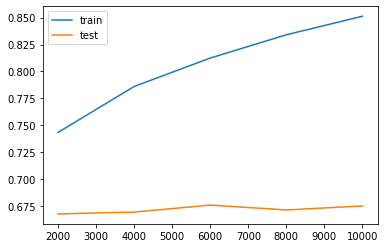

In [20]:
lines = df_maxfeatures.plot.line()

In [21]:
train_acc, test_acc = [], []

for i in range(2000,28000,2000):
    vect = CountVectorizer(max_features=i)

    #using Logistic Regression
    result = tokenize_features_lr(X_train, y_train, X_test, y_test, vect)
    train_acc.append(result[0])
    test_acc.append(result[1])

In [22]:
index_arr = list(range(2000,28000,2000))
df_maxfeatures = pd.DataFrame({'train': train_acc, 'test': test_acc}, columns=['train', 'test'], index=index_arr)
df_maxfeatures

,train,test
2000,0.766697,0.697793
4000,0.802425,0.700057
6000,0.825558,0.699774
8000,0.840295,0.695246
10000,0.850062,0.692982
12000,0.855674,0.695246
14000,0.861629,0.692699
16000,0.867626,0.692699
18000,0.872467,0.692982
20000,0.878122,0.692982


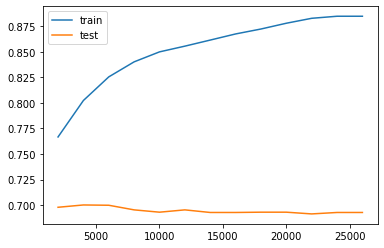

In [23]:
lines = df_maxfeatures.plot.line()

In [24]:
vect = CountVectorizer(max_features=4000)
# Logistic
tokenize_Logistic(X_train, y_train, X_test, y_test, vect)

#best estimator

vect = TfidfVectorizer(max_features=4000)
# Logistic
tokenize_Logistic(X_train, y_train, X_test, y_test, vect)

#best estimator


Logistic Regression
Features:  4000
Training Accuracy:  0.8024247097630981
Test Accuracy:  0.7000565930956423
F1 Score:  0.6992487295886146

Logistic Regression
Features:  4000
Training Accuracy:  0.7715803452855245
Test Accuracy:  0.7011884550084889
F1 Score:  0.7009988329249758


Since the test accuracy decreases after including max features with other parameters, the best estimator is to include only max features parameter of 4000

#### VADER 

In [25]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/weixin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [26]:
sid = SentimentIntensityAnalyzer()

traindf['scores'] = traindf['text'].apply(lambda text: sid.polarity_scores(text))
traindf['compound']  = traindf['scores'].apply(lambda score_dict: score_dict['compound'])
traindf['sentiment'] = traindf['compound'].apply(lambda c: 1.0 if c >= 0.05 else (0.0 if c > -0.05 and c < 0.05 else -1.0))

traindf.head()

,textID,text,selected_text,sentiment,scores,compound
12884,c64dec7448,quitsmokingdiary 5 Weeks tomorrow since givin...,YAAAAAAYY!,1.0,"{'neg': 0.077, 'neu': 0.697, 'pos': 0.226, 'co...",0.5181
21407,29ea58598a,good afternoon.,good afternoon.,1.0,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",0.4404
5958,02eceebc50,"Thanks for the follow, Doug. I like that hat",Thanks,1.0,"{'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'comp...",0.6597
22238,b5d02c31a7,I really want to!! But it`s one of my few fre...,I really want to!! But it`s one of my few free...,1.0,"{'neg': 0.0, 'neu': 0.785, 'pos': 0.215, 'comp...",0.6680
3644,7d2ea67b66,TGIF!!! But also sad that this is last day I g...,TGIF!!! But also sad that this is last day I g...,1.0,"{'neg': 0.124, 'neu': 0.56, 'pos': 0.316, 'com...",0.7012


In [27]:

scores = X_test.apply(lambda text: sid.polarity_scores(text))
compound  = scores.apply(lambda score_dict: score_dict['compound'])
comp_score = compound.apply(lambda c: 1.0 if c >= 0.05 else (0.0 if c > -0.05 and c < 0.05 else -1.0))


In [28]:
metrics.accuracy_score(y_test, comp_score) #testing accuracy

0.6471420486700622

In [29]:
metrics.f1_score(y_test, comp_score, average="weighted")

0.638735588214568

In [30]:
scores = X_train.apply(lambda text: sid.polarity_scores(text))
compound  = scores.apply(lambda score_dict: score_dict['compound'])
comp_score = compound.apply(lambda c: 1.0 if c >= 0.05 else (0.0 if c > -0.010 and c < 0.010 else -1.0))


metrics.accuracy_score(y_train, comp_score) #training accuracy

0.991731996744206

In [31]:
metrics.f1_score(y_train, comp_score, average="weighted")

0.9917266212102136

### Apply to scraped data

In [32]:
tweets = pd.read_csv("data/tweets.csv")
tweets.head()

,Unnamed: 0,url,date,content,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers,device
0,0,https://twitter.com/lundp/status/1547135712536...,2012-01-04 23:59:24+00:00,Trying new iSkin protector on MacBook Pro. And...,154713571253686272,https://twitter.com/lundp,[],[],0,0,...,154713571253686272,en,"<a href=""http://itunes.apple.com/us/app/twitte...",http://itunes.apple.com/us/app/twitter/id40978...,Twitter for Mac,NaN,NaN,NaN,NaN,mac
1,1,https://twitter.com/JayDCooke/status/154713564...,2012-01-04 23:59:22+00:00,I'm ready to get on the #MacBook,154713564031090689,https://twitter.com/JayDCooke,[],[],0,0,...,154713564031090689,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,mac
2,2,https://twitter.com/Semhar/status/154713498935...,2012-01-04 23:59:07+00:00,Syncing my entire life. All my personal & DAWN...,154713498935496704,https://twitter.com/Semhar,[],[],0,0,...,154713498935496704,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,mac
3,3,https://twitter.com/JRizAnti_Tweets/status/154...,2012-01-04 23:59:04+00:00,@MsSweetShay87 yup this year i asked 4 an audi...,154713487900291074,https://twitter.com/JRizAnti_Tweets,[],[],2,0,...,154707375994060801,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,mac
4,4,https://twitter.com/laurengrumpy/status/154713...,2012-01-04 23:58:50+00:00,@comptonasswoo MacBook! I'm considering buying...,154713429821751296,https://twitter.com/laurengrumpy,[],[],1,0,...,154713429821751296,en,"<a href=""http://www.cloudhopper.com/"" rel=""nof...",http://www.cloudhopper.com/,Twitter SMS,NaN,NaN,NaN,"[User(username='Comptonasswoo', displayname='C...",mac


In [33]:
tweet_new = tweets
tweet_new['content'] = tweet_new['content'].apply(clean_text, args=(clean_config,))

In [34]:
tweet_new

,Unnamed: 0,url,date,content,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers,device
0,0,https://twitter.com/lundp/status/1547135712536...,2012-01-04 23:59:24+00:00,Trying new iSkin protector on MacBook Pro. And...,154713571253686272,https://twitter.com/lundp,[],[],0,0,...,154713571253686272,en,"<a href=""http://itunes.apple.com/us/app/twitte...",http://itunes.apple.com/us/app/twitter/id40978...,Twitter for Mac,NaN,NaN,NaN,NaN,mac
1,1,https://twitter.com/JayDCooke/status/154713564...,2012-01-04 23:59:22+00:00,I'm ready to get on the MacBook,154713564031090689,https://twitter.com/JayDCooke,[],[],0,0,...,154713564031090689,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,mac
2,2,https://twitter.com/Semhar/status/154713498935...,2012-01-04 23:59:07+00:00,Syncing my entire life. All my personal & DAWN...,154713498935496704,https://twitter.com/Semhar,[],[],0,0,...,154713498935496704,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,mac
3,3,https://twitter.com/JRizAnti_Tweets/status/154...,2012-01-04 23:59:04+00:00,"yup this year i asked 4 an audi, macbook n i ...",154713487900291074,https://twitter.com/JRizAnti_Tweets,[],[],2,0,...,154707375994060801,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,mac
4,4,https://twitter.com/laurengrumpy/status/154713...,2012-01-04 23:58:50+00:00,MacBook! I'm considering buying Civilization ...,154713429821751296,https://twitter.com/laurengrumpy,[],[],1,0,...,154713429821751296,en,"<a href=""http://www.cloudhopper.com/"" rel=""nof...",http://www.cloudhopper.com/,Twitter SMS,NaN,NaN,NaN,"[User(username='Comptonasswoo', displayname='C...",mac
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61435,61435,https://twitter.com/peterdiseth/status/1080613...,2019-01-02 23:56:28+00:00,"If you have an iPhone, you go into settings, ...",1080613828214358016,https://twitter.com/peterdiseth,[],[],1,0,...,1080579133942378496,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,"[User(username='riogreyhound', displayname='Tr...",iphone
61436,61436,https://twitter.com/SpeakingBee/status/1080613...,2019-01-02 23:56:27+00:00,I'd upgrade mine if Apple could find a way t...,1080613826624610305,https://twitter.com/SpeakingBee,[],[],1,0,...,1080584182344998912,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com,Twitter Web Client,NaN,NaN,NaN,"[User(username='joshtpm', displayname='Josh Ma...",iphone
61437,61437,https://twitter.com/cubious/status/10806137853...,2019-01-02 23:56:17+00:00,My iphone 4 is still beautiful and capable. I...,1080613785327542272,https://twitter.com/cubious,[],[],0,0,...,1080587669200097280,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,"[User(username='paulmasonnews', displayname='P...",iphone
61438,61438,https://twitter.com/Zoli812/status/10806137796...,2019-01-02 23:56:16+00:00,should have quit making their older phones s...,1080613779690450950,https://twitter.com/Zoli812,[],[],0,0,...,1080576067436494848,en,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,NaN,NaN,NaN,"[User(username='CNBCnow', displayname='CNBC No...",iphone


In [35]:
def predict_sentiment(X_train, y_train, X_test, vect):
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    lr = LogisticRegression(max_iter=500)
    lr.fit(X_train_dtm, y_train)
    y_pred_class = lr.predict(X_test_dtm)

    return y_pred_class


In [36]:
X_test_new = tweet_new.content

In [37]:
vect = CountVectorizer(max_features=4000)

prec_sentiment = predict_sentiment(X_train, y_train, X_test_new, vect)

In [38]:
tweet_new['sentiment'] = prec_sentiment
tweet_new

,Unnamed: 0,url,date,content,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers,device,sentiment
0,0,https://twitter.com/lundp/status/1547135712536...,2012-01-04 23:59:24+00:00,Trying new iSkin protector on MacBook Pro. And...,154713571253686272,https://twitter.com/lundp,[],[],0,0,...,en,"<a href=""http://itunes.apple.com/us/app/twitte...",http://itunes.apple.com/us/app/twitter/id40978...,Twitter for Mac,NaN,NaN,NaN,NaN,mac,1.0
1,1,https://twitter.com/JayDCooke/status/154713564...,2012-01-04 23:59:22+00:00,I'm ready to get on the MacBook,154713564031090689,https://twitter.com/JayDCooke,[],[],0,0,...,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,mac,1.0
2,2,https://twitter.com/Semhar/status/154713498935...,2012-01-04 23:59:07+00:00,Syncing my entire life. All my personal & DAWN...,154713498935496704,https://twitter.com/Semhar,[],[],0,0,...,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,mac,0.0
3,3,https://twitter.com/JRizAnti_Tweets/status/154...,2012-01-04 23:59:04+00:00,"yup this year i asked 4 an audi, macbook n i ...",154713487900291074,https://twitter.com/JRizAnti_Tweets,[],[],2,0,...,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,mac,0.0
4,4,https://twitter.com/laurengrumpy/status/154713...,2012-01-04 23:58:50+00:00,MacBook! I'm considering buying Civilization ...,154713429821751296,https://twitter.com/laurengrumpy,[],[],1,0,...,en,"<a href=""http://www.cloudhopper.com/"" rel=""nof...",http://www.cloudhopper.com/,Twitter SMS,NaN,NaN,NaN,"[User(username='Comptonasswoo', displayname='C...",mac,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61435,61435,https://twitter.com/peterdiseth/status/1080613...,2019-01-02 23:56:28+00:00,"If you have an iPhone, you go into settings, ...",1080613828214358016,https://twitter.com/peterdiseth,[],[],1,0,...,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,"[User(username='riogreyhound', displayname='Tr...",iphone,1.0
61436,61436,https://twitter.com/SpeakingBee/status/1080613...,2019-01-02 23:56:27+00:00,I'd upgrade mine if Apple could find a way t...,1080613826624610305,https://twitter.com/SpeakingBee,[],[],1,0,...,en,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://twitter.com,Twitter Web Client,NaN,NaN,NaN,"[User(username='joshtpm', displayname='Josh Ma...",iphone,1.0
61437,61437,https://twitter.com/cubious/status/10806137853...,2019-01-02 23:56:17+00:00,My iphone 4 is still beautiful and capable. I...,1080613785327542272,https://twitter.com/cubious,[],[],0,0,...,en,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,"[User(username='paulmasonnews', displayname='P...",iphone,1.0
61438,61438,https://twitter.com/Zoli812/status/10806137796...,2019-01-02 23:56:16+00:00,should have quit making their older phones s...,1080613779690450950,https://twitter.com/Zoli812,[],[],0,0,...,en,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,NaN,NaN,NaN,"[User(username='CNBCnow', displayname='CNBC No...",iphone,0.0


In [39]:
tweet_new.to_csv("tweets_sentiment_countvect.csv")

### Using SHAP

### Using whole dataset

In [40]:
vect = CountVectorizer(max_features=4000)
X_train_dtm = vect.fit_transform(X_train) # sparse also works but Explanation slicing is not yet supported
X_test_dtm = vect.transform(tweet_new['content'])

model = LogisticRegression(max_iter=500)
model.fit(X_train_dtm, y_train)

explainer = shap.LinearExplainer(model, X_train_dtm, feature_dependence="independent")
shap_values = explainer.shap_values(X_test_dtm)
X_test_array = X_test_dtm.toarray()


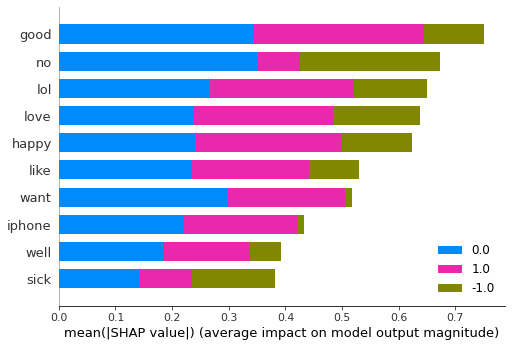

In [41]:
shap.summary_plot(shap_values, X_test_array, feature_names=vect.get_feature_names(), class_names = model.classes_, max_display=10)
#max_display=X.shape[1]

In [42]:
model.classes_

array([-1.,  0.,  1.])

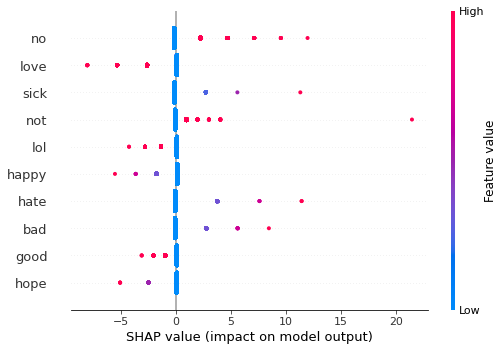

In [43]:
shap.summary_plot(shap_values[0], X_test_array, feature_names=vect.get_feature_names(), max_display=10)

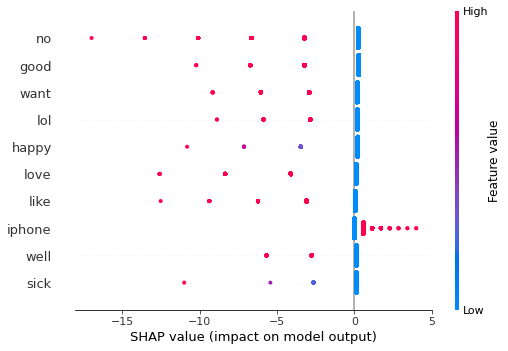

In [44]:
shap.summary_plot(shap_values[1], X_test_array, feature_names=vect.get_feature_names(), max_display=10)

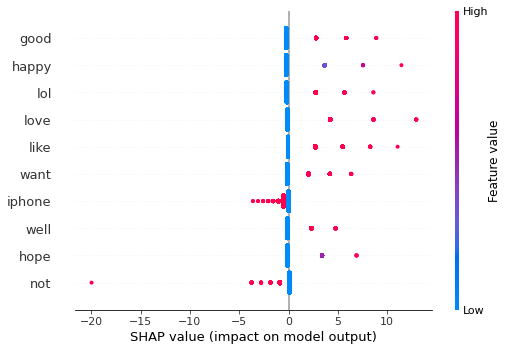

In [45]:
shap.summary_plot(shap_values[2], X_test_array, feature_names=vect.get_feature_names(), max_display=10)

In [46]:
vect = CountVectorizer(max_features=2000)
X_train_dtm = vect.fit_transform(X_train) # sparse also works but Explanation slicing is not yet supported
X_test_dtm = vect.transform(tweet_new['content'])

model = LogisticRegression(max_iter=500)
model.fit(X_train_dtm, y_train)

explainer = shap.LinearExplainer(model, X_train_dtm, feature_dependence="independent")
shap_values = explainer.shap_values(X_test_dtm)
X_test_array = X_test_dtm.toarray()


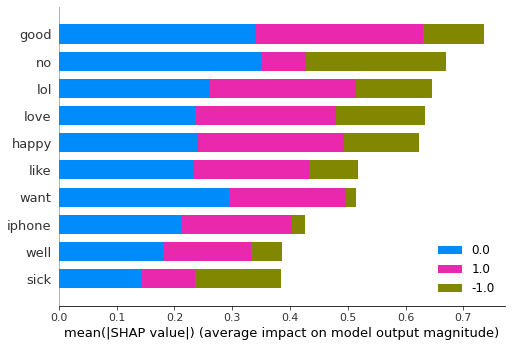

In [47]:
shap.summary_plot(shap_values, X_test_array, feature_names=vect.get_feature_names(), class_names = model.classes_, max_display=10)
#max_display=X.shape[1]

In [48]:
# using vader

sid = SentimentIntensityAnalyzer()
tweet_new_vader = tweet_new
tweet_new_vader['scores'] = tweet_new_vader['content'].apply(lambda text: sid.polarity_scores(text))
tweet_new_vader['compound']  = tweet_new_vader['scores'].apply(lambda score_dict: score_dict['compound'])
tweet_new_vader['sentiment'] = tweet_new_vader['compound'].apply(lambda c: 1.0 if c >= 0.05 else (0.0 if c > -0.05 and c < 0.05 else -1.0))

tweet_new_vader.head()

,Unnamed: 0,url,date,content,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers,device,sentiment,scores,compound
0,0,https://twitter.com/lundp/status/1547135712536...,2012-01-04 23:59:24+00:00,Trying new iSkin protector on MacBook Pro. And...,154713571253686272,https://twitter.com/lundp,[],[],0,0,...,http://itunes.apple.com/us/app/twitter/id40978...,Twitter for Mac,NaN,NaN,NaN,NaN,mac,-1.0,"{'neg': 0.193, 'neu': 0.704, 'pos': 0.103, 'co...",-0.2878
1,1,https://twitter.com/JayDCooke/status/154713564...,2012-01-04 23:59:22+00:00,I'm ready to get on the MacBook,154713564031090689,https://twitter.com/JayDCooke,[],[],0,0,...,http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,mac,1.0,"{'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'comp...",0.3612
2,2,https://twitter.com/Semhar/status/154713498935...,2012-01-04 23:59:07+00:00,Syncing my entire life. All my personal & DAWN...,154713498935496704,https://twitter.com/Semhar,[],[],0,0,...,http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,mac,-1.0,"{'neg': 0.132, 'neu': 0.868, 'pos': 0.0, 'comp...",-0.4404
3,3,https://twitter.com/JRizAnti_Tweets/status/154...,2012-01-04 23:59:04+00:00,"yup this year i asked 4 an audi, macbook n i ...",154713487900291074,https://twitter.com/JRizAnti_Tweets,[],[],2,0,...,http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,mac,1.0,"{'neg': 0.0, 'neu': 0.927, 'pos': 0.073, 'comp...",0.1280
4,4,https://twitter.com/laurengrumpy/status/154713...,2012-01-04 23:58:50+00:00,MacBook! I'm considering buying Civilization ...,154713429821751296,https://twitter.com/laurengrumpy,[],[],1,0,...,http://www.cloudhopper.com/,Twitter SMS,NaN,NaN,NaN,"[User(username='Comptonasswoo', displayname='C...",mac,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [49]:
tweet_new_vader

,Unnamed: 0,url,date,content,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers,device,sentiment,scores,compound
0,0,https://twitter.com/lundp/status/1547135712536...,2012-01-04 23:59:24+00:00,Trying new iSkin protector on MacBook Pro. And...,154713571253686272,https://twitter.com/lundp,[],[],0,0,...,http://itunes.apple.com/us/app/twitter/id40978...,Twitter for Mac,NaN,NaN,NaN,NaN,mac,-1.0,"{'neg': 0.193, 'neu': 0.704, 'pos': 0.103, 'co...",-0.2878
1,1,https://twitter.com/JayDCooke/status/154713564...,2012-01-04 23:59:22+00:00,I'm ready to get on the MacBook,154713564031090689,https://twitter.com/JayDCooke,[],[],0,0,...,http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,NaN,mac,1.0,"{'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'comp...",0.3612
2,2,https://twitter.com/Semhar/status/154713498935...,2012-01-04 23:59:07+00:00,Syncing my entire life. All my personal & DAWN...,154713498935496704,https://twitter.com/Semhar,[],[],0,0,...,http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,mac,-1.0,"{'neg': 0.132, 'neu': 0.868, 'pos': 0.0, 'comp...",-0.4404
3,3,https://twitter.com/JRizAnti_Tweets/status/154...,2012-01-04 23:59:04+00:00,"yup this year i asked 4 an audi, macbook n i ...",154713487900291074,https://twitter.com/JRizAnti_Tweets,[],[],2,0,...,http://twitter.com,Twitter Web Client,NaN,NaN,NaN,NaN,mac,1.0,"{'neg': 0.0, 'neu': 0.927, 'pos': 0.073, 'comp...",0.1280
4,4,https://twitter.com/laurengrumpy/status/154713...,2012-01-04 23:58:50+00:00,MacBook! I'm considering buying Civilization ...,154713429821751296,https://twitter.com/laurengrumpy,[],[],1,0,...,http://www.cloudhopper.com/,Twitter SMS,NaN,NaN,NaN,"[User(username='Comptonasswoo', displayname='C...",mac,0.0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61435,61435,https://twitter.com/peterdiseth/status/1080613...,2019-01-02 23:56:28+00:00,"If you have an iPhone, you go into settings, ...",1080613828214358016,https://twitter.com/peterdiseth,[],[],1,0,...,http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,"[User(username='riogreyhound', displayname='Tr...",iphone,1.0,"{'neg': 0.0, 'neu': 0.965, 'pos': 0.035, 'comp...",0.0772
61436,61436,https://twitter.com/SpeakingBee/status/1080613...,2019-01-02 23:56:27+00:00,I'd upgrade mine if Apple could find a way t...,1080613826624610305,https://twitter.com/SpeakingBee,[],[],1,0,...,http://twitter.com,Twitter Web Client,NaN,NaN,NaN,"[User(username='joshtpm', displayname='Josh Ma...",iphone,1.0,"{'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'comp...",0.8384
61437,61437,https://twitter.com/cubious/status/10806137853...,2019-01-02 23:56:17+00:00,My iphone 4 is still beautiful and capable. I...,1080613785327542272,https://twitter.com/cubious,[],[],0,0,...,http://twitter.com/download/iphone,Twitter for iPhone,NaN,NaN,NaN,"[User(username='paulmasonnews', displayname='P...",iphone,1.0,"{'neg': 0.0, 'neu': 0.534, 'pos': 0.466, 'comp...",0.8625
61438,61438,https://twitter.com/Zoli812/status/10806137796...,2019-01-02 23:56:16+00:00,should have quit making their older phones s...,1080613779690450950,https://twitter.com/Zoli812,[],[],0,0,...,http://twitter.com/download/android,Twitter for Android,NaN,NaN,NaN,"[User(username='CNBCnow', displayname='CNBC No...",iphone,-1.0,"{'neg': 0.043, 'neu': 0.957, 'pos': 0.0, 'comp...",-0.1027


In [50]:
tweet_new_vader.to_csv("tweets_sentiment_vader.csv")